# Regularización de los pesos

Ahora que hemos caracterizado el problema del sobreajuste, podemos introducir algunas técnicas estándar para regularizar modelos. Recuerde que siempre podemos mitigar el sobreajuste saliendo y recopilando más datos de entrenamiento. Eso puede ser costoso, llevar mucho tiempo o estar completamente fuera de nuestro control, haciéndolo imposible a corto plazo. Por ahora, podemos asumir que ya tenemos tantos datos de alta calidad como nuestros recursos lo permitan y centrarnos en las técnicas de regularización.

Recuerde que en nuestro ejemplo de regresión polinomial podríamos limitar la capacidad de nuestro modelo simplemente modificando el grado del polinomio ajustado. De hecho, limitar el número de características es una técnica popular para mitigar el sobreajuste. Sin embargo, simplemente dejar de lado las características puede ser una medida demasiado drástica. Siguiendo con el ejemplo de regresión polinomial, considere lo que podría suceder con entradas de alta dimensión. Las extensiones naturales de polinomios a datos multivariados se denominan *monomios*, que son simplemente productos de potencias de variables. El grado de un monomio es la suma de las potencias. Por ejemplo, $x_1^2 x_2$ y $x_3 x_5^2$ son ambos monomios de grado 3.

Tenga en cuenta que el número de términos con grado $d$ aumenta rápidamente a medida que $d$ crece. Dadas las variables $k$, el número de monomios de grado $d$ es ${k - 1 + d} \choose {k - 1}$ (es decir, $k$ multiselección $d$). Incluso pequeños cambios en el grado, digamos de $2$ a $3$, aumentan drásticamente la complejidad de nuestro modelo. Por lo tanto, a menudo necesitamos una herramienta más fina para ajustar la complejidad de la función.

## Normas

Algunos de los operadores más útiles en álgebra lineal son *normas*. Informalmente, la norma de un vector nos dice cuán *grande* es un vector. La noción de *tamaño* que se considera aquí no se refiere a la dimensionalidad sino a la magnitud de los componentes.

Puede notar que las normas se parecen mucho a las medidas de distancia. De hecho, la distancia euclidiana es una norma: en concreto es la norma $L_2$. Supongamos que los elementos en el vector $n$-dimensional $\mathbf{x}$ son $x_1, \ldots, x_n$.

**La *norma* $L_2$ de $\mathbf{x}$ es la raíz cuadrada de la suma de los cuadrados de los elementos del vector:**

**$$\|\mathbf{x}\|_2 = \sqrt{\sum_{i=1}^n x_i^2},$$**


donde el subíndice $2$ a menudo se omite en las normas $L_2$, es decir, $\|\mathbf{x}\|$ es equivalente a $\|\mathbf{x}\|_2$. En codigo,
podemos calcular la norma $L_2$ de un vector de la siguiente manera.

In [ ]:
u = torch.tensor([3.0, -4.0])
torch.norm(u)

tensor(5.)

En el aprendizaje profundo, trabajamos más a menudo con la norma $L_2$ al cuadrado.

También encontrará con frecuencia **la  *norma* $L_1$**, que se expresa como la suma de los valores absolutos de los elementos del vector:

**$$\|\mathbf{x}\|_1 = \sum_{i=1}^n \left|x_i \right|.$$**


En comparación con la norma $L_2$, está menos influenciada por valores atípicos. Para calcular la norma $L_1$, componemos la función de valor absoluto con una suma sobre los elementos.

In [ ]:
torch.abs(u).sum()

tensor(7.)

Tanto la norma $L_2$ como la norma $L_1$ son casos especiales de la *norma* $L_p$ más general:

$$\|\mathbf{x}\|_p = \left(\sum_{i=1}^n \left|x_i \right|^p \right)^{1/p}.$$

De manera análoga a la norma $L_2$ de los vectores, **la *norma de Frobenius* de una matriz $\mathbf{X} \in \mathbb{R}^{m \times n}$** es la raíz cuadrada de la suma de los cuadrados de los elementos de la matriz:

**$$\|\mathbf{X}\|_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n x_{ij}^2}.$$**

La norma de Frobenius satisface todas las propiedades de las normas vectoriales. Se comporta como si fuera una norma $L_2$ de un vector en forma de matriz. Invocar la siguiente función calculará la norma de Frobenius de una matriz.

In [ ]:
torch.norm(torch.ones((4, 9)))

tensor(6.)

## Regularizacion $L_2$ (Weight Decay)

La regularización $L_2$ podría ser la técnica más utilizada para regularizar modelos de aprendizaje automático paramétrico.**). La técnica está motivada por la intuición básica de que entre todas las funciones $f$, la función $f = 0$ (que asigna el valor $0$ a todas las entradas) es, en cierto sentido, la *más simple*, y que podemos medir la complejidad de una función por su distancia a cero. Pero, ¿con qué precisión debemos medir la distancia entre una función y cero? No hay una sola respuesta correcta. De hecho, ramas enteras de las matemáticas, incluidas partes del análisis funcional y la teoría de los espacios de Banach, están dedicadas a responder a este problema.

Una interpretación simple podría ser medir la complejidad de una función lineal $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$ por alguna norma de su vector de peso, por ejemplo, $\| \mathbf{w} \|^2$. El método más común para asegurar un vector de peso pequeño es agregar su norma como término de penalización al problema de minimizar la pérdida. Por lo tanto, reemplazamos nuestro objetivo original, *minimizar la pérdida de predicción en las etiquetas de entrenamiento*, con un nuevo objetivo, *minimizar la suma de la pérdida de predicción y el término de penalización*. Ahora, si nuestro vector de peso crece demasiado, nuestro algoritmo de aprendizaje podría enfocarse en minimizar la norma de peso $\| \mathbf{w} \|^2$ vs. minimizar el error de entrenamiento. Eso es exactamente lo que queremos. Para ilustrar las cosas en el código, revivamos nuestro ejemplo anterior de la clase de regresión lineal. Allí, nuestra pérdida fue dada por

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Recuerde que $\mathbf{x}^{(i)}$ son las características, $y^{(i)}$ son etiquetas para todos los ejemplos de datos $i$ y $(\mathbf{w}, b)$ son los parámetros de peso y sesgo, respectivamente. Para penalizar el tamaño del vector de peso, debemos agregar de alguna manera $\| \mathbf{w} \|^2$ a la función de pérdida, pero ¿cómo debería el modelo compensar la pérdida estándar por esta nueva penalización aditiva? En la práctica, caracterizamos esta compensación a través de la *constante de regularización* $\lambda$, un hiperparámetro no negativo que ajustamos usando datos de validación:

![Imgur](https://i.imgur.com/MJc7iXc.png)

Para $\lambda = 0$, recuperamos nuestra función de pérdida original. Para $\lambda > 0$, restringimos el tamaño de $\| \mathbf{w} \|$. Dividimos por $2$ por convención: cuando tomamos la derivada de una función cuadrática, $2$ y $1/2$ se cancelan, asegurando que la expresión para la actualización se vea bien y simple. El lector astuto podría preguntarse por qué trabajamos con la norma al cuadrado y no con la norma estándar (es decir, la distancia euclidiana). Hacemos esto por conveniencia computacional. Al elevar al cuadrado la norma $L_2$, eliminamos la raíz cuadrada, dejando la suma de cuadrados de cada componente del vector de peso. Esto hace que la derivada de la penalización sea fácil de calcular: la suma de las derivadas es igual a la derivada de la suma.




El efecto logrado es el que se ve en el siguiente gráfico donde tenemos un ejemplo con 2 pesos w1 y w2 como ejes y un función de pérdida graficada como sus curvas de nivel. El círculo celeste representa la restricción establecida a los pesos por la regularización l2 y el circulito amarillo es la combinación de pesos elegida por el modelo. Podemos observar que el modelo se acerca lo más posible al mínimo de la función mientras sigue respetando la restricción de tamaño.

![Imgur](https://i.imgur.com/L2T6rzd.gif)

Además, podría preguntarse por qué trabajamos con la norma $L_2$ en primer lugar y no, digamos, con la norma $L_1$. Una razón para trabajar con la norma $L_2$ es que impone una penalización descomunal a los pesos grandes del vector. Esto sesga nuestro algoritmo de aprendizaje hacia modelos que distribuyen el peso de manera uniforme entre una mayor cantidad de features. En la práctica, esto podría hacerlos más robustos al error de medición en una sola variable. Por el contrario, las penalizaciones de $L_1$ conducen a modelos que concentran los pesos en un pequeño conjunto de características disminuyendo los otros pesos a cero. Esto se llama *selección de características*, lo que puede ser deseable por otras razones.


## Regresión lineal de alta dimensión

Podemos ilustrar los beneficios de la pérdida de peso a través de un ejemplo sintético simple.












In [ ]:
%matplotlib inline
import torch
from torch import nn
from matplotlib_inline import backend_inline

Primero, **generamos algunos datos como antes**

**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**


Elegimos que nuestra etiqueta sea una función lineal de nuestras entradas, alterada por el ruido gaussiano con media cero y desviación estándar de 0,01. Para que los efectos del sobreajuste sean pronunciados, podemos aumentar la dimensionalidad de nuestro problema a $d = 200$ y trabajar con un pequeño conjunto de entrenamiento que contiene solo 20 ejemplos.

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)


## Implementación desde cero

A continuación, implementaremos la regularización de los pesos desde cero, simplemente agregando la penalización de $L_2$ al cuadrado a la función objetivo original.

### **Iniciando parámetros del modelo**

Primero, definiremos una función para inicializar aleatoriamente los parámetros de nuestro modelo.

In [ ]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### **Definiendo la Norma de Penalización $L_2$**

Quizás la forma más conveniente de implementar esta penalización es elevar al cuadrado todos los términos y sumarlos.


In [ ]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### **Definición del ciclo de entrenamiento**

El siguiente código ajusta un modelo en el conjunto de entrenamiento y lo evalúa en el conjunto de prueba. El único cambio aquí es que nuestra pérdida ahora incluye el término de penalización.


In [ ]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting
            # makes `l2_penalty(w)` a vector whose length is `batch_size`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

### [**Training without Regularization**]

We now run this code with `lambd = 0`,
disabling weight decay.
Note that we overfit badly,
decreasing the training error but not the
test error---a textbook case of overfitting.


L2 norm of w: 12.920145034790039


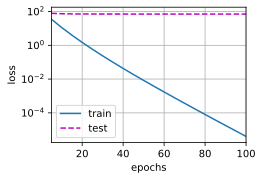

In [ ]:
train(lambd=0)

### [**Using Weight Decay**]

Below, we run with substantial weight decay.
Note that the training error increases
but the test error decreases.
This is precisely the effect
we expect from regularization.


L2 norm of w: 0.38386446237564087


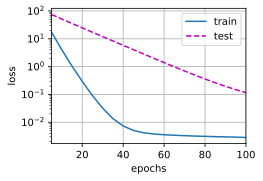

In [ ]:
train(lambd=3)

## **Implementación concisa**

Debido a que la regularización de los pesos es omnipresente en la optimización de redes neuronales, Pytorch lo hace especialmente conveniente, ya que lo integra en el propio algoritmo de optimización para facilitar su uso en combinación con cualquier función de pérdida. 

En el siguiente código, especificamos el hiperparámetro de regularización de pesos directamente a través de `weight_decay` al instanciar nuestro optimizador. De forma predeterminada, PyTorch regulariza tanto los pesos como los bias simultáneamente. Aquí solo establecemos `weight_decay` para el peso, por lo que el parámetro de bias b no se regularizará.


In [ ]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())


**Las gráficas se ven idénticas a aquellas cuando implementamos la regularización de pesos desde cero**. Sin embargo, funcionan considerablemente más rápido y son más fáciles de implementar, un beneficio que será más pronunciado para problemas más grandes.

L2 norm of w: 13.410585403442383


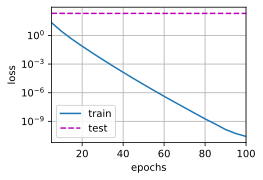

In [ ]:
train_concise(0)

L2 norm of w: 0.36591649055480957


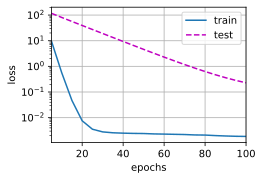

In [ ]:
train_concise(3)

# Robustez a través de perturbaciones

Otra noción útil de simplicidad es la suavidad, es decir, que la función no debe ser sensible a pequeños cambios en sus entradas. Por ejemplo, cuando clasificamos imágenes, esperaríamos que agregar algo de ruido aleatorio a los píxeles sea en su mayoría inofensivo.

Cuando se entrena una red profunda con muchas capas, inyectar ruido a las entradas impone suavidad solo en el mapeo de entrada y salida. Si llevamos esta idea más allá e inyectamos ruido en cada capa de la red antes de calcular la capa subsiguiente durante el entrenamiento.

La idea, llamada **dropout**, consiste en inyectar ruido mientras se calcula cada capa interna durante el forward, y se ha convertido en una técnica estándar para entrenar redes neuronales. El método se llama **dropout** (abandono) porque literalmente **abandona** algunas neuronas durante el entrenamiento. A lo largo del entrenamiento, en cada iteración, el dropout estándar consiste en poner a cero una fracción de las neuronas en cada capa antes de calcular la capa siguiente.

El desafío clave entonces es cómo inyectar este ruido. Una idea es inyectar el ruido de una manera *imparcial* para que el valor esperado de cada capa, mientras se dejan fijas las otras, sea igual al valor que habría tomado sin el ruido.

En la regularización de dropout estándar, se elimina el sesgo de cada capa mediante la normalización por la fracción de nodos que se retuvieron (no se abandonaron). En otras palabras, con *probabilidad de abandono* $p$, cada activación intermedia $h$ se reemplaza por una variable aleatoria $h'$ de la siguiente manera:

$$
\begin{aligned}
h' =
\begin{cases}
     0 & \text{  with probability } p \\
     \frac{h}{1-p} & \text{otherwise}
\end{cases}
\end{aligned}
$$

Por diseño, la esperanza permanece sin cambios, es decir, $E[h'] = h$.



## Dropout en la práctica

El MLP con una capa oculta y 5 unidades ocultas que se ve en la figura del lado izquierdo, se transforma en el del lado derecho cuando aplicamos dropout sobre dicha capa, poniendo a cero cada unidad oculta con una probabilidad $p$. El resultado puede verse como una red que contiene solo un subconjunto de las neuronas originales. En la figura, se eliminan $h_2$ y $h_5$. En consecuencia, el cálculo de las salidas ya no depende de $h_2$ o $h_5$ y su gradiente respectivo también se desvanece al realizar backpropagation. De esta manera, el cálculo de la capa de salida no puede depender demasiado de ningúnun elemento de $h_1, \ldots, h_5$.

![Imgur](https://i.imgur.com/t3AKofG.png)

Por lo general, deshabilitamos el abandono en el momento de la prueba. Dado un modelo entrenado y un nuevo ejemplo, no eliminamos ningún nodo y, por lo tanto, no necesitamos normalizar. 










## Implementación desde cero

Para implementar la función de dropout para una sola capa, debemos extraer tantas muestras de una variable aleatoria de Bernoulli (binaria) como dimensiones tenga nuestra capa, donde la variable aleatoria toma el valor $ 1 $ (mantener)
con probabilidad $1-p$ y $0$ (abandonar) con probabilidad $p$. Una forma sencilla de implementar esto es extraer primero muestras de la distribución uniforme $U[0, 1]$. Entonces podemos mantener aquellos nodos para los que la muestra correspondiente es mayor que $p$, descartando el resto.

En el siguiente código, **implementamos una función `dropout_layer` que descarta los elementos en la entrada del tensor `X` con probabilidad `dropout`**, reescalando el resto como se describe arriba: dividiendo los sobrevivientes por `1.0-dropout`.

In [ ]:
import torch
from torch import nn


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # En este caso, todas las neuronas de blanquean
    if dropout == 1:
        return torch.zeros_like(X)
    # En este caso, todas se mantienen
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

Podemos **probar la función `dropout_layer` en algunos ejemplos**.
En las siguientes líneas de código, pasamos nuestra entrada `X` a través de la capa de dropout, con probabilidades 0, 0,5 y 1, respectivamente.


In [ ]:
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  0.,  0., 10.,  0., 14.],
        [ 0., 18.,  0.,  0., 24.,  0., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### Definición de parámetros del modelo

Nuevamente, trabajamos con el conjunto de datos Fashion-MNIST. **Definimos un MLP con dos capas ocultas que contienen 256 unidades cada una.**

In [ ]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### Definición del modelo

El siguiente modelo aplica dropout a la salida de cada capa oculta (siguiendo la función de activación). Podemos establecer probabilidades de dropout para cada capa por separado. Una tendencia común es establecer una probabilidad de dropout más baja más cerca de la capa de entrada. A continuación, lo establecemos en 0.2 y 0.5 para la primera y segunda capa oculta, respectivamente. Nos aseguramos de que el dropout solo esté activo durante el entrenamiento.


In [ ]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # Use dropout solo al entrenar
        if self.training == True:
            # Añade una capa dropout después de la primera capa densa
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # Añade una capa dropout después de la segunda capa densa
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### **Entrenamiento y Pruebas**

Esto es similar al entrenamiento y prueba de los MLP descritos anteriormente.

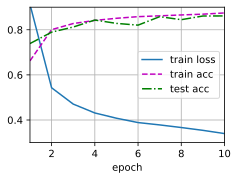

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## **Implementación concisa**

Con las API de alto nivel, todo lo que tenemos que hacer es agregar una capa de 'Dropout' después de cada capa completamente conectada, pasando la probabilidad de dropout como único argumento a su constructor. Durante el entrenamiento, la capa "Dropout" eliminará aleatoriamente las salidas de la capa anterior (o de manera equivalente, las entradas de la capa posterior) de acuerdo con la probabilidad de dropout especificada. Cuando no está en modo de entrenamiento, la capa `Dropout` simplemente pasa los datos durante la prueba.


In [ ]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

A continuación, **entrenamos y probamos el modelo**.


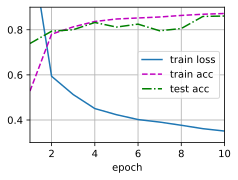

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)